In [1]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import fitsio

%load_ext autoreload

%autoreload 2

%matplotlib notebook

In [2]:
import galsim

In [3]:
import tqdm

def _get_fwhm_g1g2(psf_im):
    mom = galsim.hsm.FindAdaptiveMom(psf_im)
    return (
        mom.moments_sigma * psf_im.scale * 2.355, 
        mom.observed_shape.g1, 
        mom.observed_shape.g2)


def _measure_atm(ims, scale):
    n = ims.shape[0]
    fwhms = np.zeros((n, n))
    g1 = np.zeros_like(fwhms)
    g2 = np.zeros_like(fwhms)
    for i in tqdm.trange(n):
        for j in range(n):
            psf_im = galsim.ImageD(ims[j, i], scale=scale)
            res = _get_fwhm_g1g2(psf_im)
            fwhms[j, i] = res[0]
            g1[j, i] = res[1]
            g2[j, i] = res[2]
    return fwhms, g1, g2

In [4]:
from mdetsims.real_psf import RealPSF

d = RealPSF('test_seed10_n1e8_lhs512.fits')

 24%|██▍       | 12/50 [00:11<00:41,  1.08s/it]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 0.92883301, -0.00329899]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 68, 'nit': 3, 'warnflag': 2}
  ConvergenceWarning)
 36%|███▌      | 18/50 [00:19<00:35,  1.10s/it]/Users/Matt/miniconda3/envs/anl/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:469: ConvergenceWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'grad': array([ 1.46972081e+01, -1.74210609e-03]), 'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 57, 'nit': 12, 'warnflag': 2}
  ConvergenceWarning)
100%|██████████| 50/50 [00:30<00:00,  1.65it/s]


In [5]:
def _make_pca_image(_x, _y):
    return d.getPSF(galsim.PositionD(x=_x, y=_y)).image.array

ims = np.zeros((225, 225, 17, 17))
for y in tqdm.trange(0, 225):
    for x in range(0, 225):
        ims[y, x] = _make_pca_image(x, y)

100%|██████████| 225/225 [09:21<00:00,  2.49s/it]


In [6]:
fwhms, g1, g2 = _measure_atm(ims, 0.263)

100%|██████████| 225/225 [00:21<00:00, 10.65it/s]


In [8]:
from matplotlib.ticker import AutoMinorLocator

def plot_psf_model(fwhms, g1, g2, im_width, fig):
    """Plot a PSF model.

    Parameters
    ----------
    fwhms : np.ndarray, shape (im_width, im_width)
        A grid of the FWHM of the PSF model.
    g1 : np.ndarray, shape (im_width, im_width)
        The 1-component of the shape of the PSF.
    g2 : np.ndarray, shape (im_width, im_width)
        The 2-component of the shape of the PSF.
    im_width : int
        The width of the image in pixels.
    fig : matplotlib figure instance
        A figure to plot on.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import seaborn as sns
    >>> sns.set()
    >>> fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))
    >>> plot_psf_model(fwhm, g1, g2, 225, axs)
    """
    
    n = fwhms.shape[0]
    xt = []
    for i, _x in enumerate(np.linspace(0, im_width, n)):
        if i % 25 == 0 or i == 0 or i == n - 1:
            xt.append("%0.0f" % _x)
        else:
            xt.append('')

    kwargs = {
        'xticklabels': xt,
        'yticklabels': xt
    }

    ax = fig.add_subplot(2, 2, 1)
    sns.heatmap(
        fwhms, 
        square=True, 
        ax=ax,
        cbar_kws={'label': 'FWHM [arcsec]'},
        rasterized=True,
        **kwargs)
    ax.set_xlabel('column')
    ax.set_ylabel('row')

    whisker_kws = {
        'xtick.top': True,
        'xtick.direction': 'in',
        'ytick.right': True,
        'ytick.direction': 'in'}
    with sns.axes_style("ticks", whisker_kws):
        ax = fig.add_subplot(2, 2, 2)

        nmod = 10
        g = np.sqrt(g1**2 + g2**2)
        g /= np.mean(g)
        loc = np.linspace(0, im_width, n)
        beta = np.arctan2(g2, g1)/2
        ax.quiver(
            loc[::nmod],
            loc[::nmod],
            (g * np.cos(beta))[::nmod, ::nmod],
            (g * np.sin(beta))[::nmod, ::nmod],
            scale_units='xy',
            scale=0.075,
            headwidth=0,
            pivot='mid')
        ax.set_xlabel('column')
        ax.set_ylabel('row')
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='x', which='minor')
        ax.yaxis.set_minor_locator(AutoMinorLocator())
        ax.tick_params(axis='y', which='minor')

    ax = fig.add_subplot(2, 2, 3)
    sns.heatmap(
        g1/1e-2, square=True, ax=ax, 
        cbar_kws={'label': '$10^{2}g_{1}$'},
        rasterized=True,
        **kwargs)
    ax.set_xlabel('column')
    ax.set_ylabel('row')

    ax = fig.add_subplot(2, 2, 4)
    sns.heatmap(
        g2/1e-2, square=True, ax=ax, 
        cbar_kws={'label': '$10^{2}g_{2}$'},
        rasterized=True,
        **kwargs)
    ax.set_xlabel('column')
    ax.set_ylabel('row')

1.007798032449281 0.005998096994709659 0.006637760967688272


/Users/Matt/miniconda3/envs/anl/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The examples.directory rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2. In the future, examples will be found relative to the 'datapath' directory.
  self[key] = other[key]
/Users/Matt/miniconda3/envs/anl/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/Matt/miniconda3/envs/anl/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  self[key] = other[key]
/Users/Matt/miniconda3/envs/anl/lib/python3.6/_collections_abc.py:841: MatplotlibDeprecationWarning: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
  self[key] = other[key]
/Users/Matt/miniconda3/envs/anl/lib/python3.6/_collectio

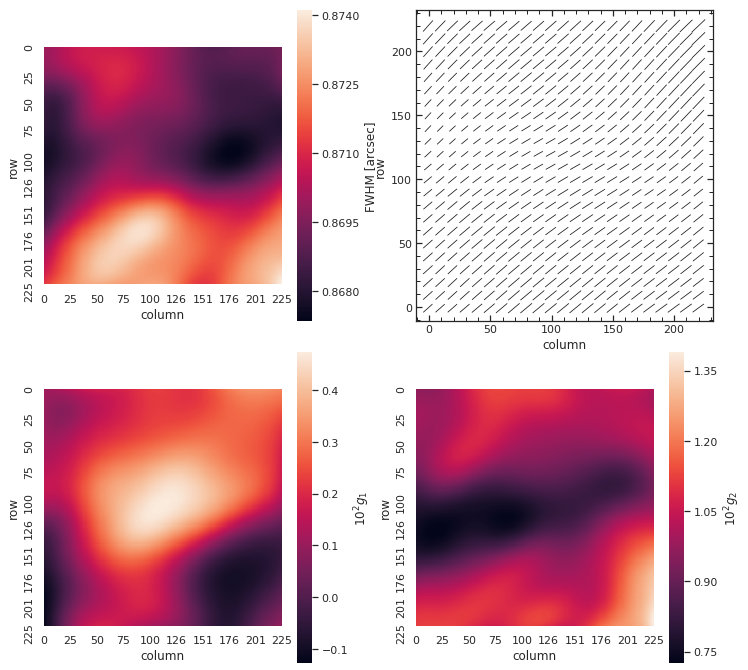

In [10]:
import matplotlib

matplotlib.rc('text', usetex=False)
sns.set()
sns.set_context("notebook")

fig = plt.figure(figsize=(12, 12))
plot_psf_model(fwhms, g1, g2, 225, fig)
plt.subplots_adjust(wspace=0.25, hspace=0.1)
plt.savefig('pspsf.png', bbox_inches='tight', pad_inches=0.1, dpi=600)

print(fwhms.max()/fwhms.min(), g1.max() - g1.min(), g2.max() - g2.min())

sns.reset_orig()

In [11]:
import treecorr

y, x = np.mgrid[:225, :225] * 0.263
cat = treecorr.Catalog(
    x=y.ravel(), y=x.ravel(), g1=g1.ravel(), g2=g2.ravel(),
    x_units='arcsec', y_units='arcsec')

gg = treecorr.GGCorrelation(
    nbins=50, min_sep=1, max_sep=60, bin_slop=0.1,
    sep_units='arcsec')

gg.process_auto(cat)
gg.finalize(np.std(g1)**2, np.std(g2)**2)

import pandas as pd
df = pd.DataFrame({'r': gg.rnom, 'xip': gg.xip, 'xim': gg.xim})

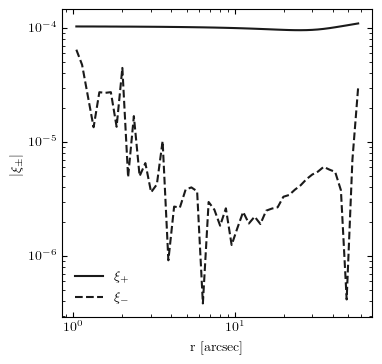

In [12]:
import matplotlib

matplotlib.rc('text', usetex=True)

fig = plt.figure(figsize=(4, 4))

ax = fig.add_subplot(1, 1, 1)

msk = (df['xip'] != 0) & (df['xim'] != 0)

ax.loglog(df['r'][msk], np.abs(df['xip'][msk]), label=r'$\xi_{+}$', color='k')
ax.loglog(df['r'][msk], np.abs(df['xim'][msk]), label=r'$\xi_{-}$', linestyle='dashed', color='k')

ax.set_xlabel(r'$\mathrm{r\ [arcsec]}$')
ax.set_ylabel(r'$|\xi_{\pm}|$')

ax.tick_params(axis='both', direction='in', which='both', right=True, top=True)

ax.legend(frameon=False)

plt.savefig('psxi.png', bbox_inches='tight', pad_inches=0.1, dpi=600)